# Stochastic Calcium Burst model with GHK currents

<div class="note">
This chapter is based on the publication "Anwar H, Hepburn I, Nedelescu H, Chen W, De Schutter E (2013) Stochastic 
Calcium Mechanisms Cause Dendritic Calcium Spike Variability. The Journal of Neuroscience, 33(40): 15848-15867".
</div>

The corresponding python script: [STEPS_Tutorial_CaBurst.py](https://github.com/CNS-OIST/STEPS_Example/tree/master/user_manual/source/API_2/scripts/STEPS_Tutorial_CaBurst.py)

This chapter builds on previous chapters by simulating a model that includes both a reaction-diffusion component as well as electrical excitability. As described in [1](#Footnotes), the two are closely coupled and this model contains ion channels where activation is both voltage-dependent and calcium-dependent. In addition, the calcium ions form an important part of the current across the membrane, further coupling the reaction-diffusion component with the electrical excitability. This chapter introduces an important new object: the GHK Current object, which is described in some detail in section [P-type Calcium channel](#P-type-Calcium-channel).

In addition, we will also introduce the STEPS parameter system that can automatically generate parameter tables from python scripts.

As in previous chapters we will go through the script, looking in some depth at new concepts, but only brief explanations will be offered of things that have been described in previous chapters. 


## Modelling solution

At the start of the script, as usual, we will import some modules, including STEPS modules and some other python modules. We will first declare all important parameters for the module such as physical 
constants, membrane properties, kinetic properties of the channels, initial conditions and so on.

### Parameters

As stated earlier, STEPS can automatically generate parameter tables from python scripts. In general, values that are used for setting properties of STEPS objects are registered as model parameters. At the end of a STEPS scripts, one can call e.g. `ExportParameters(sim, '/path/to/fileprefix', method='csv')` and STEPS will automatically generate csv files that contain the values and units of all parameters.

We start the script by import relevant modules and declaring a few parameters:

In [1]:
import steps.interface

from steps.geom import *
from steps.model import *
from steps.rng import *
from steps.saving import *
from steps.sim import *
from steps.utils import *

import math

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

###########################################################
# Simulation Parameters
###########################################################

SEED = 1234

NBRUNS = 5

EF_DT = 5.0e-6

DT =  2.0e-5
ENDT = 0.5

###########################################################
# Model Parameters
###########################################################

TEMPERATURE = 34.0 + 273.15
Q10 = 3

FARADAY = 96485.3365     # C/mol
R = 8.3144621            # J/mol K
AVOGADRO = 6.02214129e23 # /mol

Qt = math.pow(Q10, (TEMPERATURE - (23 + 273.15)) / 10)
Qt_mslo = math.pow(Q10, (TEMPERATURE - (25 + 273.15))/10)

Note that since these parameters are standard python floating point numbers, we need to make sure all of them are expressed in SI units.

There is however another way to declare parameters that will allow us to specify units, keep track of the name of the parameter, and give additional information about the parameters. This is done by using the `Parameter` class from the `utils` module (see [documentation](API_utils.rst#steps.API_2.utils.Parameter)):

In [2]:
#######################################
# Membrane Parameters
#######################################

init_pot = Parameter(-60, 'mV', Description='Initial membrane potential')
Ra = Parameter(235.7*1.0e-2, 'ohm m', Description='Bulk resistivity')
memb_capac = Parameter(1.5e-2, 'F m^-2', Description='Membrane capacitance')

The `Parameter` constructor usually takes at least two arguments: the first one is the value of the parameter and the second one is the unit this value is expressed in. As can be seen in the above code,  we can provide non-SI units and values; STEPS will then do the proper conversions automatically. 
When using the `Parameter` class, STEPS will use the name of the veriable (`init_pot`, `Ra`, etc.) as the name of the parameter in parameter tables. A list of supported units is available in the `Parameter` class [documentation](API_utils.rst#steps.API_2.utils.Parameter).

The `Parameter` constructor can then take any keyword argument as additional information about the parameter. Here we supply a description of the parameter that will be displayed in the automatically generated parameter tables.

If a `Parameter` object is involved in computations, all other values involved in the computation should be `Parameter`s as well, otherwise STEPS cannot infer the units of the value that results from the computation.
Because of this constraint, we do not use the `Parameter` class everywhere:

In [3]:
#######################################
# CaP channels parameters
#######################################

CaP_P = Parameter(2.5e-2, 'um^3 s^-1', Description='CaP single channel permeability')
CaP_ro = Parameter(38, 'um^-2', Description='CaP channels density')

# Reaction rates

vhalfm = -29.458 # mV
cvm = 8.429      # mV

def minf_cap(mV):
    vhalfm = -29.458
    cvm = 8.429
    return 1 / (1 + math.exp(-(mV - vhalfm) / cvm))

def tau_cap(mV):
    if mV >= -40:
        return 0.2702 + 1.1622 * math.exp(-(mV + 26.798) ** 2 / 164.19)
    else:
        return 0.6923 * math.exp(mV / 1089.372)

alpha_cap = VDepRate.Create(
    lambda V: (minf_cap(V * 1e3) / tau_cap(V * 1e3)) * Qt * 1e3
)
beta_cap = VDepRate.Create(
    lambda V: (1 - minf_cap(V * 1e3)) / tau_cap(V * 1e3) * Qt * 1e3
)

# Initial conditions
CaP_p = [0.92402, 0.073988, 0.0019748, 1.7569e-05]

Note that we use `VDepRate.Create(...)` instead of `VDepRate(...)` so that the resulting STEPS object is named after the variable it is attributed to.

The other parameters are declared in a similar way:

In [4]:
#######################################
# CaT channels parameters
#######################################

CaT_P = Parameter(1.65e-2, 'um^3 s^-1', Description='CaT single channel permeability')
CaT_ro = Parameter(3.7576, 'um^-2', Description='CaT channels density')

# Reaction rates

def minf_cat(mV):
    vhalfm = -52
    cvm = -5
    return 1 / (1 + math.exp((mV - vhalfm) / cvm))

def taum_cat(mV):
    if mV > -90:
        return 1 + 1 / (math.exp((mV + 40) / 9) + math.exp(-(mV + 102) / 18))
    else:
        return 1

def hinf_cat(mV):
    vhalfh = -72
    cvh = 7
    return 1 / (1 + math.exp((mV - vhalfh) / cvh))

def tauh_cat(mV):
    return (15 + 1 / (math.exp((mV + 32) / 7)))

alpham_cat = VDepRate.Create(lambda V: minf_cat(V * 1e3) / taum_cat(V * 1e3) * 1e3)
betam_cat = VDepRate.Create(lambda V: (1 - minf_cat(V * 1e3)) / taum_cat(V * 1e3) * 1e3)

alphah_cat = VDepRate.Create(lambda V: hinf_cat(V * 1e3) / tauh_cat(V * 1e3) * 1e3)
betah_cat = VDepRate.Create(lambda V: (1 - hinf_cat(V * 1e3)) / tauh_cat(V * 1e3) * 1e3)

# Initial conditions
CaT_p = [
    [0.58661, 0.23687, 0.023912],   # h0
    [0.10564, 0.042658, 0.0043063], # h1
]

#######################################
# BK channels parameters
#######################################

BK_G = Parameter(210, 'pS', Description='BK single channel conductance')
BK_ro = Parameter(2.0238, 'um^-2', Description='BK channels density')
BK_rev = Parameter(-77, 'mV', Description='BK channel reversal potential')

# Reaction rates

#Units (1)
Qo = 0.73
Qc = -0.67

#Units (/s)
pf0 = 2.39
pf1 = 5.4918
pf2 = 24.6205
pf3 = 142.4546
pf4 = 211.0220

pb0 = 3936
pb1 = 687.3251
pb2 = 234.5875
pb3 = 103.2204
pb4 = 11.6581

#Units(/M)
k1 = 1.0e6

#Units(/s)
onoffrate = 1.0e3

L0 = 1806

#Units (M)
Kc = 8.63e-6
Ko = 0.6563e-6

BK_f = k1*onoffrate*Qt_mslo
BKo_b = Ko*k1*onoffrate*Qt_mslo
BKc_b = Kc*k1*onoffrate*Qt_mslo

BK_f0 = VDepRate.Create(
    lambda V: pf0 * Qt_mslo * (math.exp((Qo * FARADAY * V) / (R * TEMPERATURE)))
)
BK_f1 = VDepRate.Create(
    lambda V: pf1 * Qt_mslo * (math.exp((Qo * FARADAY * V) / (R * TEMPERATURE)))
)
BK_f2 = VDepRate.Create(
    lambda V: pf2 * Qt_mslo * (math.exp((Qo * FARADAY * V) / (R * TEMPERATURE)))
)
BK_f3 = VDepRate.Create(
    lambda V: pf3 * Qt_mslo * (math.exp((Qo * FARADAY * V) / (R * TEMPERATURE)))
)
BK_f4 = VDepRate.Create(
    lambda V: pf4 * Qt_mslo * (math.exp((Qo * FARADAY * V) / (R * TEMPERATURE)))
)
BK_oc_f = [BK_f0, BK_f1, BK_f2, BK_f3, BK_f4]

BK_b0 = VDepRate.Create(
    lambda V: pb0 * Qt_mslo * (math.exp((Qc * FARADAY * V) / (R * TEMPERATURE)))
)
BK_b1 = VDepRate.Create(
    lambda V: pb1 * Qt_mslo * (math.exp((Qc * FARADAY * V) / (R * TEMPERATURE)))
)
BK_b2 = VDepRate.Create(
    lambda V: pb2 * Qt_mslo * (math.exp((Qc * FARADAY * V) / (R * TEMPERATURE)))
)
BK_b3 = VDepRate.Create(
    lambda V: pb3 * Qt_mslo * (math.exp((Qc * FARADAY * V) / (R * TEMPERATURE)))
)
BK_b4 = VDepRate.Create(
    lambda V: pb4 * Qt_mslo * (math.exp((Qc * FARADAY * V) / (R * TEMPERATURE)))
)
BK_oc_b = [BK_b0, BK_b1, BK_b2, BK_b3, BK_b4]

# Initial conditions
BK_p = [
    [0.99997,    4.3619e-07, 4.1713e-09, 4.4449e-11, 6.3132e-14],
    [2.5202e-05, 1.1765e-06, 6.6148e-08, 2.4392e-09, 4.0981e-11],
]

#######################################
# SK channels parameters
#######################################

SK_G = Parameter(10, 'pS', Description='SK single channel conductance')
SK_ro = Parameter(0.31, 'um^-2', Description='SK channels density')
SK_rev = Parameter(-77, 'mV', Description='SK channel reversal potential')

# Reaction rates

#Units (/s)
invc1 = 80
invc2 = 80
invc3 = 200

invo1 = 1000
invo2 = 100

diro1 = 160
diro2 = 1200

#Units ( /s M)

dirc2 = 200e6
dirc3 = 160e6
dirc4 = 80e6

invc1_t = invc1*Qt
invc2_t = invc2*Qt
invc3_t = invc3*Qt

invo1_t = invo1*Qt
invo2_t = invo2*Qt

diro1_t = diro1*Qt
diro2_t = diro2*Qt

dirc2_t = dirc2*Qt/3.0
dirc3_t = dirc3*Qt/3.0
dirc4_t = dirc4*Qt/3.0

# Intital conditions
SK_C1_p= 0.96256
SK_C2_p= 0.036096
SK_C3_p= 0.0010829
SK_C4_p= 6.4973e-06

SK_O1_p= 0.00017326
SK_O2_p= 7.7967e-05

#######################################
# Leak channels parameters
#######################################

L_G = Parameter(0.04, 'pS', Description='Leak single channel conductance')
L_ro = Parameter(0.25, 'um^-2', Description='Leak channels density')
L_rev = Parameter(-61, 'mV', Description='Leak channel reversal potential')

#######################################
# Ca pump channels parameters
#######################################

P_ro = Parameter(6.022141, 'um^-2', Description='Ca2+ pump density')

# Reaction rates

P_f = 3e9
P_b = 1.75e4
P_k = 7.255e4

#######################################
# Calcium buffering parameters
#######################################

# Ca concentrations

Ca_oconc = 2e-3
Ca_iconc = 45e-9

# Mg concentrations

Mg_conc = 590e-6

# Buffer concentrations

iCBsf_conc = 27.704e-6
iCBCaf_conc = 2.6372e-6
iCBsCa_conc= 1.5148e-6
iCBCaCa_conc= 0.14420e-6

CBsf_conc= 110.82e-6
CBCaf_conc= 10.549e-6
CBsCa_conc= 6.0595e-6
CBCaCa_conc= 0.57682e-6

PV_conc= 3.2066e-6
PVCa_conc= 16.252e-6
PVMg_conc= 60.541e-6

# Diffusion constants

DCST = 0.223e-9 # Ca
DCB = 0.028e-9  # Calbindin (CB)
DPV = 0.043e-9  # Parvalbumin (PV)

# Reaction rates

CBf_f_kcst = 4.35e7
CBf_b_kcst = 35.8

CBs_f_kcst = 0.55e7
CBs_b_kcst = 2.6

PVca_f = 10.7e7
PVca_b = 0.95

PVmg_f_kcst = 0.8e6
PVmg_b_kcst = 25

###########################################################
# Mesh Parameters
###########################################################

mesh_file = 'meshes/caburst_cyl80.msh'

## Model specification

Since this is a relatively large model we will split its description up into several sections. We first create the species and channels that will be used in the model:

In [5]:
###########################################################
# Biochemical model
###########################################################

mdl = Model()
with mdl:
    # Species
    Pump, CaPump, PV, PVMg, PVCa, Mg = Species.Create()
    Ca = Species.Create(valence=2)

    # Calbindin
    CBs, CBf, CBsCa, CBfCa, CBmob, CBimmob = SubUnitState.Create()
    CBsSU, CBfSU, CBmobSU = SubUnit.Create(
        [CBs, CBsCa], [CBf, CBfCa], [CBmob, CBimmob]
    )
    CB = Complex.Create([CBsSU, CBfSU, CBmobSU], statesAsSpecies=True)

    # Channels
    CaPc, CaPo = SubUnitState.Create()
    CaP_SU = SubUnit.Create([CaPc, CaPo])
    CaPchan = Channel.Create([CaP_SU, CaP_SU, CaP_SU])
    
    CaTmc, CaTmo, CaThc, CaTho = SubUnitState.Create()
    CaTm_SU = SubUnit.Create([CaTmc, CaTmo])
    CaTh_SU = SubUnit.Create([CaThc, CaTho])
    CaTchan = Channel.Create([CaTm_SU, CaTm_SU, CaTh_SU])

    BK, BKCa, BKopen, BKclose = SubUnitState.Create()
    BKCaSU = SubUnit.Create([BK, BKCa])
    BKocSU = SubUnit.Create([BKopen, BKclose])
    BKchan = Channel.Create([BKCaSU, BKCaSU, BKCaSU, BKCaSU, BKocSU])

    SK_C1, SK_C2, SK_C3, SK_C4, SK_O1, SK_O2 = SubUnitState.Create()
    SKchan = Channel.Create([SK_C1, SK_C2, SK_C3, SK_C4, SK_O1, SK_O2])

    Leak = SubUnitState.Create()
    L = Channel.Create([Leak])

All ion channels involve the creation of `SubUnitState`s and `SubUnit`s, as we already saw in the [corresponding chapter](STEPS_Tutorial_Efield.ipynb). There is however one difference compared to previous chapters: the `Ca` species is created with the `valence` keyword parameter. This sets the net elementary electrical charge per calcium ion, which in this example for Ca2+ is +2. This is necessary for using GHK currents as we will see later in this chapter.

### Calcium dynamics

The following lines of code describe the calcium and calcium buffer reactions and diffusion. Since these are 'ordinary' dynamics with no voltage-dependence we will not look look at this part in detail. A more detailed explanation is offered in [1](#Footnotes) and [2](#Footnotes).

In [6]:
with mdl:
    r = ReactionManager()

    vsys = VolumeSystem.Create()
    with vsys:
        # PVCa
        PV + Ca <r[1]> PVCa
        r[1].K = PVca_f, PVca_b

        # PVMg
        PV + Mg <r[1]> PVMg
        r[1].K = PVmg_f_kcst, PVmg_b_kcst

        with CB[...]:
            # Fast binding
            CBf + Ca <r[1]> CBfCa
            r[1].K = CBf_f_kcst, CBf_b_kcst

            # Slow binding
            CBs + Ca <r[1]> CBsCa
            r[1].K = CBs_f_kcst, CBs_b_kcst

        diff_Ca   = Diffusion.Create(Ca, DCST)
        diff_CB   = Diffusion.Create(CB[:, :, CBmob], DCB)
        diff_PV   = Diffusion.Create(PV, DPV)
        diff_PVCa = Diffusion.Create(PVCa, DPV)
        diff_PVMg = Diffusion.Create(PVMg, DPV)
        
    ssys = SurfaceSystem.Create()
    with ssys:
        # Ca Pump
        Pump.s + Ca.i <r[1]> CaPump.s >r[2]> Pump.s
        r[1].K = P_f, P_b
        r[2].K = P_k

### P-type Calcium channel

The P-type calcium channel is a different type of ion channel to those we have seen before. In previous chapters we saw 
Hodgkin-Huxley sodium and potassium channels that conducted an Ohmic current. The sodium and potassium ions in that situation 
were not explicitly simulated, which was reasonable because those ions were not involved in other processes we were 
interested in, and we could assume their concentrations inside and outside the cell were not altered significantly during their 
conduction. However, with calcium we need a different approach. Here calcium is involved in intracellular processes such as 
potassium channel-activation (as we will see), buffering and diffusion, and so we must simulate the influx of calcium through these
P-type channels. Furthermore, the Ohmic approximation is no longer sufficient for our purposes. The large differences between 
intracellular and extracellular concentration along with large changes in intracellular concentration mean that, in effect, channel 
conductance has some voltage and concentration dependence and is described much better by the GHK flux equation. The GHK flux equation itself 
is derived under certain simplifying assumptions that are good approximations for many ion channels, specifically 
those where channel occupancy and competition are negligible. Please see [3](#Footnotes) for further discussion on the use of the GHK flux 
equation and the behaviour of the GHK current object in STEPS. It is worth noting that use of the GHK flux equation means that 
(instead of conductance) we must specify the channel's permeability, which can be more difficult to parameterize. 

The P-type calcium channel kinetics are described in detail in [1](#Footnotes). The `CaPchan` channel object was created before and contains three identical `CaP_SU` subunits that can either be in closed (`CaPc`) or open (`CaPo`) states.

We then declare the voltage-dependent transition reaction between open and closed states. 
Remember for each of these discrete channels the voltage will be read from the local voltage
across the membrane triangle where the channel resides.

In [7]:
with mdl:
    with ssys:
        # CaP channel
        with CaPchan[...]:
            CaPc.s <r[1]> CaPo.s
            r[1].K = alpha_cap, beta_cap

We come to creating our GHK current object. This object will calculate single-channel current for a given
channel state by the GHK flux equation:

$$
I_{s}=P_{s}z_{s}^{2}\frac{V_{m}F^{2}}{RT}\frac{[S]_{i}-[S]_{o}exp(-z_{s}V_{m}F/RT)}{1-exp(-z_{s}V_{m}F/RT)}
$$

where $I_{s}$ is the single-channel current (amps) of ion S, $P_{s}$ is the single-channel permeability of ion S ($m^{3}.s^{-1}$), $z_{s}$ is the valence of ion S, $V_{m}$ is the membrane voltage (volts), $F$ is the Faraday constant, $R$ is the gas constant, $T$ is temperature (Kelvin), $[S]_{i}$ is the intracellular concentration of ion S ($mol.m^{-3}$) and $[S]_{o}$ is the extracellular concentration of ion S ($mol.m^{-3}$).

When a GHK current is applied in STEPS it (optionally) results in movement of ions between the 'outer' and 'inner' compartments, the direction of which will depend 
on the sign of the current and the valence of the ions. 

Many of the values required for calculating a GHK current are simulation variables, such as concentrations and voltage, simulation constants such as 
temperature, or fixed constants such as the Faraday constant and the gas constant. Such values are either known or can be found by STEPS during runtime and so are not part of 
object construction, with the exception of single-channel permeability which we will come to later. Like we saw in [Simulating membrane potential](STEPS_Tutorial_Efield.ipynb), we then create the `GHKCurr` object. There are also optional keyword arguments (`virtual_oconc` and `computeflux`) that we will explain further.

In [8]:
with mdl:
    with ssys:
        OC_CaP = GHKCurr.Create(
            CaPchan[CaPo, CaPo, CaPo], Ca, CaP_P,
            computeflux=True,
            virtual_oconc=Ca_oconc,
        )

First let's look at the `virtual_oconc` argument. This option allows us to not explicitly model the extracellular ('outer') concentration of the ion, which is useful because
often the extracellular compartment is not modelled. This option, rather, allows a fixed 'outer' concentration for the ion to be 
specified and that number will be used in the GHK flux calculations. The value of the parameter `Ca_oconc` that we declared earlier is 2mM.

The other optional argument is `computeflux`. This flag (which defaults to True) tells STEPS whether to model this GHK current process as ion transport 
or not. If `computeflux` is True, then the calculated GHK current will result in transport of ions between the 'outer' and 'inner' compartments. 
For example, if over some 0.01ms time step, somewhere on the membrane a mean current of approximately 1.6pA is calculated through a membrane channel to which a GHK current is applied, 
then for an ion of valence 2+ this means that 50 ions moved from one compartment to the other. The direction of movement depends on the signs of the current
and the ion valence. The movement only occurs between surface tetrahedrons surrounding the membrane triangles in which the channels reside and so, for ions 
where this kind of process occurs, for accuracy it is necessary to model diffusion of these ions at least within the inner compartment 
and often within both compartments. This can be an expensive computation, particularly where concentrations are in the millimolar range, which shows the value of the `computeflux`
flag- if the GHK flux is applied to an ion which does not have any other particularly important effects in the model other than its effect on membrane 
excitability (a possible example is potassium) then it may be a good labour-saver to clamp 'inner' and 'outer' concentrations of the ion and turn off the transport 
of ions as an approximation. However, in this model if we set `computeflux` to False then the result would be no intracellular calcium, which is 
obviously not desirable, and so the `computeflux` flag is set to True, as it usually will be for most ions in most models.  

The first positional argument, like for ohmic currents, is the conducting channel state(s). Here, the channel opens when all its subunits are in the open `CaPo` state.

The second positional argument is the ion that will carry the current. For calcium (and only for calcium) we used `valence=2` to specify a valence of 2. 'Valence' can be an ambiguous term, but 
here it means the net elementary electrical charge per ion, which in this example for Ca2+ is +2. Negative valences can of course be specified by using a negative number. It is essential that a valence is set for any ion that will be used for a GHK current in the simulation. If no valence is specified the result will be an error. 

The third positional argument (`CaP_P`) corresponds to single-channel permeability. Because conductance is not constant for a GHK current (apart from under certain unusual 
conditions) one value for a conductance parameter does not suffice. However, since single-channel permeability is often rather a difficult parameter
to define, STEPS does provide functionality for estimating the permeability. So we have two options for setting single-channel permeability: 
giving it directly to the GHKCurr constructor; or giving the result of a call to [steps.API_2.model.GHKCurr.PInfo](API_model.rst#steps.API_2.model.GHKCurr.PInfo) to estimate the permeability from data. The first is straightforward and simply means providing single-channel 
permeability in S.I. units of cubic metres / second. In this model the CaP channel permeability `CaP_P` was set to 2.5e-20 cubic metres / second [4](#Footnotes). If we did not provide the permeability during construction, we could also write

```python
    OC_CaP.P = CaP_P
```

The second option, the [steps.API_2.model.GHKCurr.PInfo](API_model.rst#steps.API_2.model.GHKCurr.PInfo) function, requires some explanation. In effect, the conductance of a channel that is modelled 
by the GHK flux equation varies with 
voltage (see below figure) with a dependence on the 'outer' and 'inner' concentrations of the ion (in fact conductance is only constant with voltage 
when these concentrations are equal), as well as weakly on temperature. 

<figure>
<img src="images/GHK_K.png">
<figcaption>
Figure 1: A single-channel GHK flux in the physiological range for a typical monovalent cation compared to an Ohmic approximation. The GHK flux is calculated with single-channel permeability of 9e-20 cubic metres / second, fixed extracellular concentration of 4mM, fixed intracellular concentration of 155mM and temperature of 20 Celsius. The single-channel Ohmic conductance is 20pS with reversal potential -77mV.
</figcaption>
</figure>
    

STEPS is able to estimate single-channel permeability from single-channel conductance, but for STEPS to do so the user must supply 
information about the conditions under which the conductance was measured, and in theory this should be enough to find the single-channel permeability since it is 
assumed constant (although there are occasions when permeability too can have some weak voltage dependence [3](#Footnotes), 
which is, however, currently not possible to model with STEPS). Specifically, the [steps.API_2.model.GHKCurr.PInfo](API_model.rst#steps.API_2.model.GHKCurr.PInfo) function requires arguments of:
estimated single-channel conductance [5](#Footnotes) (units: Siemens), one voltage within the range at which conductance was measured (Volts), temperature (Kelvin), 'outer' concentration 
of the ion (molar), and 'inner' concentration of the ion (molar). Since the valence of the ion is known it is not necessary to supply that information to 
the [steps.API_2.model.GHKCurr.PInfo](API_model.rst#steps.API_2.model.GHKCurr.PInfo) function. So, for example, for some GHKcurrent object called `K_GHK`, if we measured single-channel conductance 
as 20pS in a small voltage range around -22mV at 20 degrees Celsius (293.15 Kelvin) with an estimated extracellular ion concentration of 4mM and 
intracellular concentration of 155mM, then we could create the current with

```python
    K_Pinfo = GHKCurr.PInfo(g = 20e-12, V = -22e-3, T = 293.15, oconc = 4e-3, iconc = 155e-3)
    K_GHK = GHKCurr.Create(Kchan[Ko], K, K_Pinfo)
```

and the single-channel permeability would be set to approximately 9e-20 cubic metres / second. The behaviour of such a channel is shown in Figure 1.

We are now familiar, through aspects discussed so far in this chapter and other chapters, with most of the concepts applied for this model, so 
a very detailed description is not necessary for most remaining parts of the model. We move on to our other three ion channels in the model.

### T-type Calcium channel

Like the P-type Calcium channel, transitions between channel states of the T-type Calcium channel are voltage-dependent and we model the calcium current as a GHK current

In [9]:
with mdl:
    with ssys:
        # CaT channel
        with CaTchan[...]:
            CaTmc.s <r[1]> CaTmo.s
            r[1].K = alpham_cat, betam_cat
            
            CaThc.s <r[1]> CaTho.s
            r[1].K = alphah_cat, betah_cat
        OC_CaT = GHKCurr.Create(
            CaTchan[CaTmo, CaTmo, CaTho], Ca, CaT_P,
            computeflux=True,
            virtual_oconc=Ca_oconc,
        )

### BK-type Calcium-activated Potassium channel

The BK channel in the model undergoes both voltage-dependent and non-voltage dependent processes. This is an example of Channel States interacting with Species through surface reactions. Here we will notice that Channel subunit states (e.g. `BK`) appear alongside Species (`Ca`) in reactions:

In [10]:
with mdl:
    with ssys:
        # BK channel
        with BKchan[..., BKclose]:
            BK.s + Ca.i <r[1]> BKCa.s
            r[1].K = BK_f, BKc_b

        with BKchan[..., BKopen]:
            BK.s + Ca.i <r[1]> BKCa.s
            r[1].K = BK_f, BKo_b

        with BKchan[...]:
            BKclose.s <r[1]> BKopen.s

            BK_f = CompDepRate.Create(lambda s: BK_oc_f[s.Count(BKCa)], [BKchan])
            BK_b = CompDepRate.Create(lambda s: BK_oc_b[s.Count(BKCa)], [BKchan])
            r[1].K = BK_f, BK_b
        OC_BK = OhmicCurr.Create(BKchan[..., BKopen], BK_G, BK_rev)

The potassium current is modeled with an [steps.API_2.model.OhmicCurr](API_model.rst#steps.API_2.model.OhmicCurr) objects. All states in which the `BKocSU` subunit is in the `BKopen` state are conducting states, demonstrating the support for multiple conducting/permeable states for a channel.

Note also that the transition between `BKclose` and `BKopen` is declared with a complex-dependent rate (`CompDepRate`). As we saw in the [multi-state complexes](STEPS_Tutorial_Complexes.ipynb#Expressing-cooperativity-with-complex-dependent-reaction-rates) chapter, the rate of the reaction will be determined depending on the state of the channel. Here, the rate depends on the number of `BKCaSU` subunits that are bound to calcium. We declared tables of reaction rate constants (`BK_oc_f` and `BK_oc_b`) and we access the correct value by counting the number of subunits that have bound calcium (`BK_oc_f[s.Count(BKCa)]`).

### SK-type Calcium-activated Potassium channel

The SK channel does not have any voltage dependence, and contains two conducting states

In [11]:
with mdl:
    with ssys:
        # SK channel
        with SKchan[...]:
            ((SK_C1.s + Ca.i <r[1]> SK_C2.s)\
                      + Ca.i <r[2]> SK_C3.s)\
                      + Ca.i <r[3]> SK_C4.s
            r[1].K = dirc2_t, invc1_t
            r[2].K = dirc3_t, invc2_t
            r[3].K = dirc4_t, invc3_t
            
            SK_C3.s <r[1]> SK_O1.s
            SK_C4.s <r[2]> SK_O2.s
            r[1].K = diro1_t, invo1_t
            r[2].K = diro2_t, invo2_t
        OC_SK = OhmicCurr.Create(SKchan[SK_O1|SK_O2], SK_G, SK_rev)

### Leak channel

Although another option for setting the leak would have been to (later) set `sim.membrane.Res`, the leak conductance is described as a leak channel:

In [12]:
with mdl:
    with ssys:
        # Leak current channel
        OC_L = OhmicCurr.Create(L[Leak], L_G, L_rev)

## Geometry specification

This model is set up with a relatively simple geometry: a cylinder of diameter 2um and 80um length. The membrane across which we compute potential does not include the ends of the cylinder.

In [13]:
###########################################################
# Mesh and compartmentalization
###########################################################

mesh = TetMesh.LoadGmsh(mesh_file, 1e-6)

with mesh:
    cyto = Compartment.Create(mesh.tets, vsys)

    ends = [mesh.bbox.min.z, mesh.bbox.max.z]
    memb_tris = TriList(tri for tri in mesh.surface if tri.center.z not in ends)
    memb = Patch.Create(memb_tris, cyto, None, ssys)
    
    submemb_tets = TetList()
    for tri in memb.tris:
        submemb_tets |= tri.tetNeighbs

    membrane = Membrane.Create([memb])

We also find the submembrane tetrahedrons, that is all tetrahedrons connected to a membrane triangle from the intracellular side.

## Simulation with TetOpSplit

### Initialization

We first create the random number generator, the partition scheme, and the simulation object:

In [14]:
###########################################################
# Simulation
###########################################################

rng = RNG('mt19937', 512, SEED)

part = LinearMeshPartition(mesh, 1, 1, MPI.nhosts)

sim = Simulation('TetOpSplit', mdl, mesh, rng, part, calcMembPot=True)

Model checking:
No errors were found


We then declare the data to be saved, as seen in previous chapters:

In [15]:
rs = ResultSelector(sim)

Currents = rs.SUM(rs.TRIS(memb.tris).OC_CaP.I) << \
           rs.SUM(rs.TRIS(memb.tris).OC_CaT.I) << \
           rs.SUM(rs.TRIS(memb.tris).OC_BK.I) << \
           rs.SUM(rs.TRIS(memb.tris).OC_SK.I)

Pot = rs.TET(0, 0, 0).V

CaConcs = rs.cyto.Ca.Conc << \
         (rs.SUM(rs.TETS(submemb_tets).Ca.Count) / (AVOGADRO * submemb_tets.Vol * 1e3))

BKstates = rs.memb.LIST(*BKchan[...]).Count

sim.toSave(Currents, Pot, CaConcs, BKstates, dt=DT)

We will save the total currents through the membrane for each GHK and ohmic currents, the membrane potential, the intracellular and submembrane calcium concentration, and the distribution of states of the BK channel.

The data will be saved to an HDF5 file, as we saw in a [previous chapter](STEPS_Tutorial_DataSaving.ipynb). We setup the initial state for each run and run `NBRUNS` simulations: 

In [ ]:
with HDF5Handler('Caburst') as hdf:
    sim.toDB(hdf, 'CaBurstSim')

    for i in range(NBRUNS):
        sim.newRun()

        # Setting initial conditions
        area = Parameter(memb.Area, 'm^2')

        sim.memb.Pump.Count = round(P_ro * area)

        for s in CaPchan[...]:
            sim.memb.LIST(s).Count = round(CaP_ro*area*CaP_p[s.Count(CaPo)])

        for s in CaTchan[...]:
            hCnt, mCnt = s.Count(CaTho), s.Count(CaTmo)
            sim.memb.LIST(s).Count = round(CaT_ro*area*CaT_p[hCnt][mCnt])

        for s in BKchan[...]:
            isOpen, nbCa = s.Count(BKopen), s.Count(BKCa)
            sim.memb.LIST(s).Count = round(BK_ro*area*BK_p[isOpen][nbCa])

        sim.memb.SKchan[SK_C1].Count = round(SK_ro*area*SK_C1_p)
        sim.memb.SKchan[SK_C2].Count = round(SK_ro*area*SK_C2_p)
        sim.memb.SKchan[SK_C3].Count = round(SK_ro*area*SK_C3_p)
        sim.memb.SKchan[SK_C4].Count = round(SK_ro*area*SK_C4_p)
        sim.memb.SKchan[SK_O1].Count = round(SK_ro*area*SK_O1_p)
        sim.memb.SKchan[SK_O2].Count = round(SK_ro*area*SK_O2_p)

        sim.memb.L[Leak].Count = round(L_ro * area)
        
        sim.cyto.Ca.Conc = Ca_iconc
        sim.cyto.Mg.Conc = Mg_conc

        sim.cyto.CB[CBs,   CBf,   CBimmob].Conc = iCBsf_conc
        sim.cyto.CB[CBsCa, CBf,   CBimmob].Conc = iCBCaf_conc
        sim.cyto.CB[CBs,   CBfCa, CBimmob].Conc = iCBsCa_conc
        sim.cyto.CB[CBsCa, CBfCa, CBimmob].Conc = iCBCaCa_conc

        sim.cyto.CB[CBs,   CBf,   CBmob].Conc = CBsf_conc
        sim.cyto.CB[CBsCa, CBf,   CBmob].Conc = CBCaf_conc
        sim.cyto.CB[CBs,   CBfCa, CBmob].Conc = CBsCa_conc
        sim.cyto.CB[CBsCa, CBfCa, CBmob].Conc = CBCaCa_conc

        sim.cyto.PV.Conc = PV_conc
        sim.cyto.PVCa.Conc = PVCa_conc
        sim.cyto.PVMg.Conc = PVMg_conc

        sim.EfieldDT = EF_DT

        sim.ALL(Membrane).Potential = init_pot
        sim.membrane.VolRes = Ra
        sim.membrane.Capac = memb_capac

        # Set temperature for ghk reactions
        sim.Temp = TEMPERATURE

        for j in range(1000):
            t = ENDT * j / 999
            if MPI.rank == 0:
                print(f'run {i}: {t} / {ENDT}s')
            sim.run(t)

We set a new simulation property, [steps.API_2.sim.Simulation.Temp](API_sim.rst#steps.API_2.sim.Simulation.Temp), which holds the simulation temperature. Currently, this will only influence any GHK flux rates, and 
will have no influence on any other kinetics. The value for `TEMPERATURE` is in Kelvin and corresponds to 34 degrees Celsius.

Note that, since the simulation takes much more computing time than other simulations we saw in previous chapters,  we split the call to `sim.run(ENDT)` to multiple calls interspersed with printouts giving us feedback about the progression of the simulation.

### Running the simulation

Although the simulation can be run with jupyter notebook, it would take too long to do so and it is thus more suited to parallel runs (see [corresponding chapter](STEPS_Tutorial_MPI.ipynb)). 
The corresponding python script can be downloaded here: [STEPS_Tutorial_CaBurst.py](https://github.com/CNS-OIST/STEPS_Example/tree/master/user_manual/source/API_2/scripts/STEPS_Tutorial_CaBurst.py)
The simulations can then be run with 12 cores by using e.g.:

```shell
mpirun -n 12 python3 STEPS_Tutorial_CaBurst.py
```

## Parameters export

Finally, after the simulations, we call the `ExportParameters` function to generate parameter tables for our model and simulation:

In [ ]:
if MPI.rank == 0:
    ExportParameters(sim, 'CaBurst', method='pdf', 
        hideColumns=['Defined in', 'valence Units'],
        unitsToSimplify=[
            'uM', 'uM^-1 s^-1', 'mV', 'um^2 s^-1', 'pS', 'um', 'um^2'
        ], numPrecision=5,
    )

First note that only MPI rank 0 calls this function, otherwise all ranks would try to write to the same files.

This function takes a STEPS container object as first argument (here we use the full simulation) and a file prefix as second argument. It will then generate files like `CaBurst_Parameters.pdf`, etc.

The method keyword argument specifies how the tables will be created, currently `'csv'`, `'tex'` and `'pdf'` are supported. The `'pdf'` method depends on the installation of `pdflatex` and `csv2latex` programs. If these programs are not installed, you can change `method='pdf'` to `method='csv'` in the code above.

We will not go over all the available keyword arguments for the `ExportParameters` function, further explanations are available in the [documentation](API_utils.rst#steps.API_2.utils.ExportParameters). The following figure shows some of the tables generated by the function:

<figure>
<img src="images/parameter_export_tables.png">
<figcaption>
Figure 2: Examples of tables generated with `ExportParameters`. The simulation table shows the initial state (t = 0) values along with computations that were used to derive them. The reaction table shows all reactions in the model with their associated rate constants. The parameters table shows all explicitely created `Parameter`s along with their description. The diffusion, GHKCurr and OhmicCurr tables respectively show diffusion rules, GHK currents and ohmic currents.
</figcaption>
</figure>

## Plotting the results

The corresponding python script: [STEPS_Tutorial_CaBurst_plot.py](https://github.com/CNS-OIST/STEPS_Example/tree/master/user_manual/source/API_2/scripts/STEPS_Tutorial_CaBurst_plot.py)

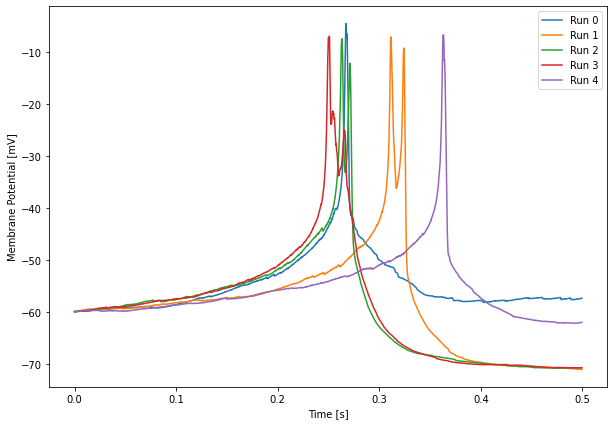

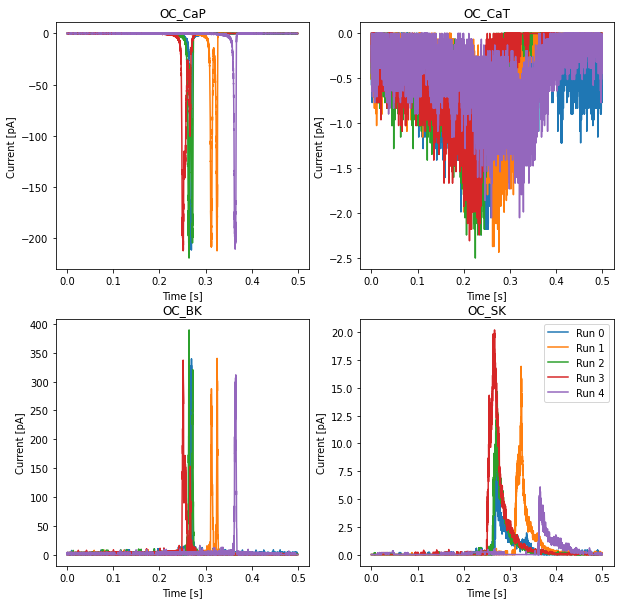

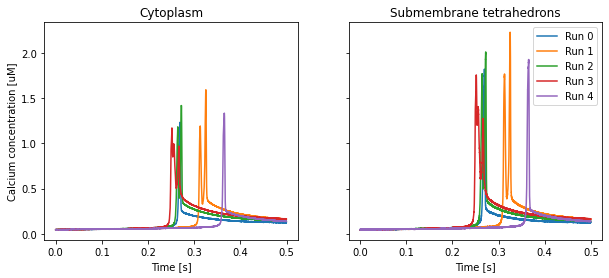

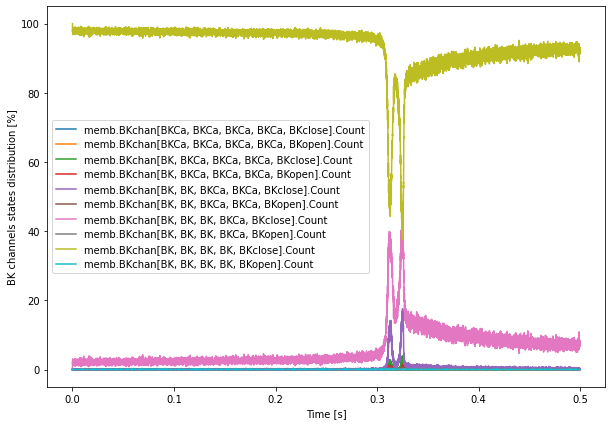

In [16]:
from matplotlib import pyplot as plt
import numpy as np

with HDF5Handler('Caburst') as hdf:
    Currents, Pot, CaConcs, BKstates =  hdf['CaBurstSim'].results

    # Membrane potential
    plt.figure(figsize=(10, 7))
    for r in range(len(Pot.time)):
        plt.plot(Pot.time[r], 1e3 * Pot.data[r,:,0], label=f'Run {r}')
    plt.legend()
    plt.xlabel('Time [s]')
    plt.ylabel('Membrane Potential [mV]')
    plt.show()
    
    # Currents
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))
    for i in range(len(Currents.data[0,0,:])):
        ax = axs[i//2][i%2]
        for r in range(len(Currents.time)):
            ax.plot(Currents.time[r], 1e12 * Currents.data[r,:,i], label=f'Run {r}')
            ax.set_title(Currents.labels[i].split('.')[-2])
        ax.set_xlabel('Time [s]')
        ax.set_ylabel('Current [pA]')
    plt.legend()
    
    # Calcium
    fig, axs = plt.subplots(1, 2, squeeze=True, sharey=True, figsize=(10, 4))
    for i in range(len(CaConcs.data[0,0,:])):
        for r in range(len(CaConcs.time)):
            axs[i].plot(CaConcs.time[r], 1e6 * CaConcs.data[r,:,i], label=f'Run {r}')
        axs[i].set_title(['Cytoplasm', 'Submembrane tetrahedrons'][i])
        axs[i].set_xlabel('Time [s]')
        if i == 0:
            axs[i].set_ylabel('Calcium concentration [uM]')
    plt.legend()
    plt.show()
    
    # BK channel states for run 1
    rind = 1
    plt.figure(figsize=(10, 7))
    totCount = np.sum(BKstates.data[rind,:,:], axis=1)
    for c in range(len(BKstates.data[rind, 0, :])):
        plt.plot(BKstates.time[rind], 100 * BKstates.data[rind,:,c] / totCount)
    plt.legend(BKstates.labels)
    plt.xlabel('Time [s]')
    plt.ylabel('BK channels states distribution [%]')
    plt.show()

## Footnotes 

1. Anwar H, Hepburn I, Nedelescu H, Chen W, De Schutter E (2013) Stochastic Calcium Mechanisms Cause Dendritic Calcium Spike Variability. The Journal of Neuroscience, 33(40): 15848-15867, doi: 10.1523/​JNEUROSCI.1722-13.2013. 
2. Anwar H, Hong S, De Schutter E (2012) Controlling Ca2+-activated K+ channels with models of Ca2+ buffering in Purkinje cells. Cerebellum, 11(3):681-93, doi: 10.1007/s12311-010-0224-3. 
3. Hepburn I, Cannon R and De Schutter E (2013) Efficient calculation of the quasi-static electrical potential on a tetrahedral mesh and its implementation in STEPS. Frontiers in Computational Neuroscience: 7:129, doi: 10.3389/fncom.2013.00129
4. The same considerations for converting membrane permeability to single-channel permeability apply as for conductance discussed in [Simulating membrane potentia](STEPS_Tutorial_Efield.ipynb), requiring some estimate of the channel density.
5. Since it is assumed that conductance is measured by estimating the slope of an I-V curve over some small voltage range, the conductance will be treated as a slope conductance for the purposes of single-channel permeability estimation.
6. We may record voltage from anywhere on the membrane surface or within the 'conduction volume' (here and in most models the conduction volume is the cytosolic compartment). 